# Webinar: NASA ORNL DAAC MODIS and VIIRS Data Tools and Services at your Fingertips
-----

### Table of Contents
*Note: Links will not work when viewed in GitHub*

* [**Introduction**](#Introduction)           
* [**Helpful Links**](#Helpful-Links)           
* [**Prerequisites**](#Prerequisites)                                                                
* [**GET products**](#GET-products)                                                              
* [**GET dates**](#GET-dates)                                                                    
* [**GET subset**](#GET-subset)                                                                  
* [**Request a time series**](#Make-a-time-series-from-multiple-subset-requests)                  
* [**Quality filtering**](#Apply-quality-filter-to-the-time-series)                                          
* [**Bonus Content**](#Bonus-Content)                                                                   
    
    [QC Table for MODIS Land Surface Temp/Emissivity (MOD11A2)](#Build-the-QC-Table-for-VNP13A1)     


# Introduction
-----

In this demo, we'll learn how to access the MODIS/VIIRS Web Service using R and efficiently prepare a time series of data for further analysis. The methods in this demo can be applied to subsets that are retrieved through the MODIS/VIIRS Global Subsetting Tool or Web Service.

First, we'll see example usage for the **dates** and **subset** web service functions. Then we'll request a time series of Enhanced Vegetation Index (EVI) from the [**VIIRS Vegetation Indices (VNP13A1)**](https://dx.doi.org/10.5067/VIIRS/VNP13A1.001) product and learn how to apply custom filtering based on user-specified quality criteria.  

**We will start with this plot EVI that assumes all data quality is satisfactory:**    
<img src="pictures/evi2_unfiltered_py.png" style="width: 750px;">

**And finish with this plot of filtered EVI that indicates the percentage of pixels meeting our custom quality criteria:**
<img src="pictures/evi2_filtered_py.png" style="width: 750px;">


# Helpful Links
-----

[ORNL DAAC MODIS Website](https://modis.ornl.gov/)     

[MODIS/VIIRS Web Service](https://modis.ornl.gov/data/modis_webservice.html)     

[VNP13A1 User Guide](https://lpdaac.usgs.gov/sites/default/files/public/product_documentation/vnp13_user_guide_atbd_v2.1.2.pdf)

# Prerequisites
-----

**Libraries:**       

* **requests**   --- for submitting GET requests    
* **pandas**     --- for convenient data frame structure
* **numpy**      --- for fast arrays
* **json**       --- for translating json response to R data frame (optional)  
* **datetime**   --- for convenient reformatting of dates (optional)
* **matplotlib** --- for plotting     

In [1]:
import requests
import json
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl


## GET products
------

Visit the ORNL DAAC MODIS/VIIRS Web Service help page for descriptions and usage examples of each web service function:
https://modis.ornl.gov/data/modis_webservice.html

Set the REST API endpoint and test connectivity using **requests.get**.

**GET products:**
https://modis.ornl.gov/rst/api/v1/products

In [2]:
url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'} # JSON response; text response: header = {'Accept': 'text/csv'}

response = requests.get("https://modis.ornl.gov/rst/api/v1/products", headers=header)
print("Response status: " + str(response.status_code))

products = json.loads(response.text)['products']
print(type(products))
products[1]

Response status: 200
<class 'list'>


{'product': 'MCD12Q1',
 'description': 'MODIS/Terra+Aqua Land Cover Type (LC) Yearly L3 Global 500 m SIN Grid',
 'frequency': 'Yearly',
 'resolution_meters': 500}

We will submit a subset request for the **VIIRS Enhanced Vegetation Index 2 (VNP13A1)** for a site in Great Smoky Mountains National Park near Gatlinburg, TN (35.71326, -83.51047). Around 11,000 acres burned during the [Chimney Tops 2 Fire](https://www.nps.gov/grsm/learn/news/nps-releases-review-of-chimney-tops-2-fire.htm) in November and December 2016.


## GET dates
------

```https://modis.ornl.gov/rst/api/v1/PRODUCT/dates?latitude=LATITUDE&longitude=LONGITUDE```

The MODIS/VIIRS Web Service has a ten tile limit per request to ensure responsivity of the service and to avoid time outs. We need to make a list of available dates to iterate through while we submit our subset requests. The **dates** function returns a list of available dates for the specified coordinate and MODIS/VIIRS product.

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS/VIIRS product code as listed by **products** function   |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |

The response contains a list of two strings per available MODIS date for the requested MODIS/VIIRS product and coordinate:
* modis_date ("AYYYYDOY")    
* calendar_date ("YYYY-MM-DD")

Get the available dates for VNP13A1 at our site:

In [3]:
# Set dates request parameters
prod = 'VNP13A1'     # MODIS product
lat = '35.71326'   # Input latitude
lon = '-83.51047'   # Input longitude

response = requests.get('https://modis.ornl.gov/rst/api/v1/'+prod+'/dates?latitude='+lat+'&longitude='+lon, headers=header)
dates = json.loads(response.text)['dates']
modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]
doys = [i[-3:] for i in modis_dates]

# Print the first ten dates
print(modis_dates[0:9])

['A2012017', 'A2012025', 'A2012033', 'A2012041', 'A2012049', 'A2012057', 'A2012065', 'A2012073', 'A2012081']



## GET subset
------

The **subset** function returns the subset in either json or text/csv format. *kmAboveBelow* and *kmLeftRightight* indicate the number of kilometers above and below, left and right of the center pixel of the subset; e.g. for a 500-m product (MOD09A1) 10, 10 will result in a subset with a spatial extent covering 20.5- x 20.5-km. The subset command takes the following inputs:

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS product code as listed by **products**                  |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |
| **band**           | band ID as listed by **bands**                                |
| **startDate**      | MODIS start date as listed by **dates** ("AYYYYDOY")          |
| **endDate**        | MODIS end date as listed by **dates** ("AYYYYDOY")            |
| **kmAboveBelow**   | number of kilometers to subset above and below center pixel   |
| **kmLeftRight**    | number of kilometers to subset left and right of center pixel |


The response includes helpful metadata about the subset:

* band --- requested band
* cellsize --- cell size in meters
* header --- request url
* latitude --- latitude of center pixel of subset
* longitude --- longitude of center pixel of subset
* ncols --- number of columns in the subset
* nrows --- number of rows in the subset
* scale --- scale factor
* **subset --- subset data; one per timestep - see below**
* units --- product data units
* xllcorner --- MODIS sinusoidal x-coordinate of the lower left corner of the subset
* yllcorner --- MODIS sinusoidal y-coordinate of the lower left corner of the subset

**The subset data are stored within the subset element of the response. We'll take a look at its contents in the next step.**

In the following code block we set our subset parameters, make a simple function that combines all of them into a URL string, and submit a subset request for the first date in our list:

In [4]:
# Set the remaining subset request parameters
data_band = '500_m_16_days_EVI2'   # Daytime LST band name
qc_band = '500_m_16_days_VI_Quality' # Daytime QC band name
above_below = 2            # km above/below
left_right = 2            # km left/right

def requestURL(latitude, longitude, product, band, start_date, end_date, kmAB, kmLR):
    return(
        str(
            url+product+"/subset?"+ \
            "latitude="+str(latitude)+ \
            "&longitude="+str(longitude)+ \
            "&band="+band+ \
            "&startDate="+start_date+ \
            "&endDate="+end_date+ \
            "&kmAboveBelow="+str(kmAB)+ \
            "&kmLeftRight="+str(kmLR)
        )
    )

response = requests.get(requestURL(lat,lon,prod,data_band,modis_dates[0],modis_dates[0],above_below,left_right), headers=header)
subset = json.loads(response.text)
subset

{'xllcorner': '-7541804.45',
 'yllcorner': '3969200.01',
 'cellsize': 463.312716528,
 'nrows': 9,
 'ncols': 9,
 'band': '500_m_16_days_EVI2',
 'units': 'EVI2 ratio - No units',
 'scale': '0.0001',
 'latitude': 35.71326,
 'longitude': -83.51047,
 'header': 'https://modis.ornl.gov/rst/api/v1/VNP13A1/subset?latitude=35.71326&longitude=-83.51047&band=500_m_16_days_EVI2&startDate=A2012017&endDate=A2012017&kmAboveBelow=2&kmLeftRight=2',
 'subset': [{'modis_date': 'A2012017',
   'calendar_date': '2012-01-17',
   'band': '500_m_16_days_EVI2',
   'tile': 'h11v05',
   'proc_date': '2018137160532',
   'data': [1920,
    2032,
    2042,
    1744,
    1887,
    1588,
    1588,
    1932,
    2154,
    2048,
    1778,
    1448,
    1493,
    1493,
    1388,
    1698,
    2326,
    2385,
    1593,
    1772,
    1593,
    2186,
    1779,
    1519,
    1760,
    2001,
    2375,
    1922,
    2152,
    2090,
    2090,
    1554,
    1720,
    2169,
    1954,
    2244,
    1497,
    1497,
    1778,
    206

### Format subset response as familiar "CSV-like" structure

We can reformat the time series into a structure more suitable for plotting by converting the **data** column into a data frame and transposing it such that each row is one step in the time series and each column is a pixel. 

The resulting structure matches what we would get by reading a CSV from the Global Tool into a data frame:

In [5]:
# Get data as a pandas data frame so that rows are timesteps and columns are pixels
format_subset = pd.DataFrame([subset['subset'][0]['data']])
format_subset

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,1920,2032,2042,1744,1887,1588,1588,1932,2154,2048,...,1905,1958,1958,2643,1569,1128,1851,2955,3292,2222


We're not going to plot the raster grids in the Python version of the demo. But here's how you capture the subset metadata:

In [6]:
# Get subset metadata
nrow = int(subset['nrows']) # number of rows
ncol = int(subset['ncols']) # number of columns
xllcorner = float(subset['xllcorner']) # lower left hand corner x-coordinate
yllcorner = float(subset['yllcorner']) # lower left hand corner y-coordinate
cellsize = float(subset['cellsize']) # pixel size
scale = float(subset['scale']) # scale factor

------
## Make a time series from multiple subset requests

Because of the ten tile limit imposed by the web service, we have to submit multiple requests to get a complete time series. 

Use the same input parameters as above and loop through the *dates* variable, submitting requests for the **2-band Enhanced Vegetation Index (500_m_16_days_EVI2)** and **VI Quality (500_m_16_days_VI_Quality)** layers for each timestep:

In [7]:
# Initialize lists to store the returned LST and QC data
proddata = []
qcdata = []

# Iterate through the list of dates and submit subset requests.
for dt in range(0,len(modis_dates), 1):
    date = modis_dates[dt]
    
    # Submit request
    subset = requests.get(
        requestURL(lat,lon,prod,data_band,date,date,above_below,left_right), 
        headers=header
    )
    # Append data column (subset element) to list
    proddata.append(json.loads(subset.text)['subset'][0]['data'])
        
    # Build QC request url and submit request    
    qcsubset = requests.get(
        requestURL(lat,lon,prod,qc_band,date,date,above_below,left_right),
        headers=header
    )
    # Loop through list of dictionaries inside the subset key and append data to qcdata
    qcdata.append(json.loads(qcsubset.text)['subset'][0]['data'])
    
# Make a pandas data frame from each list
prodvalues = pd.DataFrame(proddata, index=calendar_dates)
qcvalues = pd.DataFrame(qcdata, index=calendar_dates)

# Write the data to CSVs
prodvalues.to_csv('data/prodvalues.csv', sep=',', header=False)
qcvalues.to_csv('data/qcvalues.csv', sep=',', header=False)

1. Apply the scale factor    
2. Calculate the mean and standard deviation of each timestep as a new data frame called **prodstats**    
3. Plot the result:

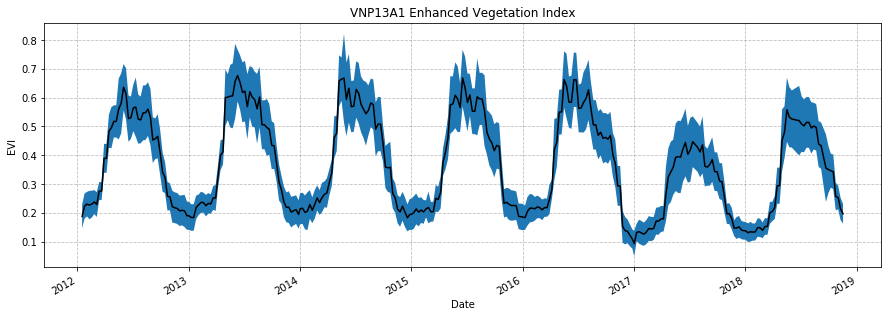

In [8]:
prodvalues_scaled = prodvalues*float(scale)
prodstats = pd.DataFrame(
    np.column_stack(
        [
            prodvalues_scaled.mean(axis=1), 
            prodvalues_scaled.std(axis=1), 
            prodvalues_scaled.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)
        ]
    ), 
    columns=['mean', 'sd', 'quality'], 
    index=pd.to_datetime(calendar_dates)
)

plt.rcParams['figure.figsize'] = (15,5)
fig, ax1 = plt.subplots()

ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('EVI')
ax1.plot(prodstats.index, prodstats['mean'], 'k-')
ax1.fill_between(prodstats.index, prodstats['mean']-prodstats['sd'], prodstats['mean']+prodstats['sd'])
ax1.tick_params(axis='y')
fig.autofmt_xdate()


plt.title("VNP13A1 Enhanced Vegetation Index")
plt.show()



## Apply quality filter to the time series
------

So let's figure out what the quality layer values mean. Here is the QC table from the [VNP13A1 User Guide](https://lpdaac.usgs.gov/sites/default/files/public/product_documentation/vnp13_user_guide_atbd_v2.1.2.pdf) (p. 43):

<img src="pictures/VNP13A1_QC.png" style="width: 600px;">

Get a list of unique values from the QC layer time series. Iterate through the unique QC values, get the binary representation of each and determine quality descriptions for each group in the QC Table from the User Guide:

In [9]:
qcvals = sorted(pd.unique(qcvalues.values.ravel()))
print("These are the unique QC values: "+ str(qcvals))

# Create empty list to store QC bit information
QC_Data = []

# Iterate through the list of unique QC integers and create a list of bits and descriptions for each.
for integer in qcvals:
    bits = list(map(int, list("{0:b}".format(integer).zfill(16))))
    
    # MODLAND_QA bits description
    if (bits[14] == 0 and bits[15] == 0): MODLAND_QA = 'LST GOOD'
    if (bits[14] == 0 and bits[15] == 1): MODLAND_QA = 'LST Produced,Other Quality'
    if (bits[14] == 1 and bits[15] == 0): MODLAND_QA = 'No Pixel,clouds'
    if (bits[14] == 1 and bits[15] == 1): MODLAND_QA = 'No Pixel, Other QA'
        
    # VI_usefulness bits description
    if (bits[10] == 0 and bits[11] == 0 and bits[12] == 0 and bits[13] == 0): VI_usefulness = 'Highest quality'
    if (bits[10] == 0 and bits[11] == 0 and bits[12] == 0 and bits[13] == 1): VI_usefulness = 'Lower quality'
    if (bits[10] == 0 and bits[11] == 0 and bits[12] == 1 and bits[13] == 0): VI_usefulness = 'Decreasing quality 1'
    if (bits[10] == 0 and bits[11] == 0 and bits[12] == 1 and bits[13] == 1): VI_usefulness = 'Decreasing quality 2'
    if (bits[10] == 0 and bits[11] == 1 and bits[12] == 0 and bits[13] == 0): VI_usefulness = 'Decreasing quality 3'
    if (bits[10] == 0 and bits[11] == 1 and bits[12] == 0 and bits[13] == 1): VI_usefulness = 'Decreasing quality 4'
    if (bits[10] == 0 and bits[11] == 1 and bits[12] == 1 and bits[13] == 0): VI_usefulness = 'Decreasing quality 5'
    if (bits[10] == 0 and bits[11] == 1 and bits[12] == 1 and bits[13] == 1): VI_usefulness = 'Decreasing quality 6'
    if (bits[10] == 1 and bits[11] == 0 and bits[12] == 0 and bits[13] == 0): VI_usefulness = 'Decreasing quality 7'
    if (bits[10] == 1 and bits[11] == 0 and bits[12] == 0 and bits[13] == 1): VI_usefulness = 'Decreasing quality 8'
    if (bits[10] == 1 and bits[11] == 0 and bits[12] == 1 and bits[13] == 0): VI_usefulness = 'Decreasing quality 9'
    if (bits[10] == 1 and bits[11] == 0 and bits[12] == 1 and bits[13] == 1): VI_usefulness = 'Decreasing quality 10'
    if (bits[10] == 1 and bits[11] == 1 and bits[12] == 0 and bits[13] == 0): VI_usefulness = 'Decreasing quality 11'
    if (bits[10] == 1 and bits[11] == 1 and bits[12] == 0 and bits[13] == 1): VI_usefulness = 'Quality so low that it is not useful'
    if (bits[10] == 1 and bits[11] == 1 and bits[12] == 1 and bits[13] == 0): VI_usefulness = 'L1B data faulty'
    if (bits[10] == 1 and bits[11] == 1 and bits[12] == 1 and bits[13] == 1): VI_usefulness = 'Not useful for any other reason/not processed'

    # Aerosol_quantity bits description
    if (bits[8] == 0 and bits[9] == 0): Aerosol_quantity = 'Climatology'
    if (bits[8] == 0 and bits[9] == 1): Aerosol_quantity = 'Low'
    if (bits[8] == 1 and bits[9] == 0): Aerosol_quantity = 'Average'
    if (bits[8] == 1 and bits[9] == 1): Aerosol_quantity = 'High'
    
    # Adjacent_cloud_detected bits description
    if (bits[7] == 0): Adjacent_cloud_detected = 'No'
    if (bits[7] == 1): Adjacent_cloud_detected = 'Yes'
    
    # Atmosphere_BRDF_correction_performed bits description
    if (bits[6] == 0): Atmosphere_BRDF_correction_performed = 'No'
    if (bits[6] == 1): Atmosphere_BRDF_correction_performed = 'Yes'
    
    # Mixed_clouds bits description
    if (bits[5] == 0): Mixed_clouds = 'No'
    if (bits[5] == 1): Mixed_clouds = 'Yes'

    # Aerosol_quantity bits description
    if (bits[2] == 0 and bits[3] == 0 and bits[4] == 0): Land_Water_flag = 'Land and desert'
    if (bits[2] == 0 and bits[3] == 0 and bits[4] == 1): Land_Water_flag = 'land no desert'
    if (bits[2] == 0 and bits[3] == 1 and bits[4] == 0): Land_Water_flag = 'inland water'
    if (bits[2] == 0 and bits[3] == 1 and bits[4] == 1): Land_Water_flag = 'sea water'
    if (bits[2] == 1 and bits[3] == 0 and bits[4] == 1): Land_Water_flag = 'coastal'

    # Possible_snow_ice bits description
    if (bits[1] == 0): Possible_snow_ice = 'No'
    if (bits[1] == 1): Possible_snow_ice = 'Yes'

    # Possible_shadow bits description
    if (bits[0] == 0): Possible_shadow = 'No'
    if (bits[0] == 1): Possible_shadow = 'Yes'

    
    # Append this integers bit values and descriptions to list
    QC_Data.append(
        [integer] + \
        bits + \
        [
            MODLAND_QA, 
            VI_usefulness, 
            Aerosol_quantity, 
            Adjacent_cloud_detected,
            Atmosphere_BRDF_correction_performed,
            Mixed_clouds,
            Land_Water_flag,
            Possible_snow_ice,
            Possible_shadow
        ]
    )

# Convert QC bits and descriptions to pandas data frame
QC_Data = pd.DataFrame(
    QC_Data, 
    columns=[
        'Integer_Value', 
        'Bit15', 'Bit14', 'Bit13', 'Bit12', 'Bit11', 'Bit10', 'Bit9', 'Bit8', 
        'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 
        'MODLAND_QA', 'VI_usefulness', 'Aerosol_quantity', 'Adjacent_cloud_detected',
        'Atmosphere_BRDF_correction_performed','Mixed_clouds','Land_Water_flag',
        'Possible_snow_ice','Possible_shadow'
    ]
)

# Print the first five rows
QC_Data.head()

These are the unique QC values: [2061, 2065, 2116, 2120, 2124, 2185, 2189, 2257, 2261, 2325, 2445, 2517, 2521, 3358, 3362, 3366, 3418, 18713, 34893, 34961, 34965, 35033, 35037, 35097, 35101, 35105, 35157, 35221, 35225, 35293, 35297, 51229, 51485, 51489, 51493]


,Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
0,2061,0,0,0,0,1,0,0,0,0,...,1,"LST Produced,Other Quality",Decreasing quality 2,Climatology,No,No,No,land no desert,No,No
1,2065,0,0,0,0,1,0,0,0,0,...,1,"LST Produced,Other Quality",Decreasing quality 3,Climatology,No,No,No,land no desert,No,No
2,2116,0,0,0,0,1,0,0,0,0,...,0,LST GOOD,Lower quality,Low,No,No,No,land no desert,No,No
3,2120,0,0,0,0,1,0,0,0,0,...,0,LST GOOD,Decreasing quality 1,Low,No,No,No,land no desert,No,No
4,2124,0,0,0,0,1,0,0,0,0,...,0,LST GOOD,Decreasing quality 2,Low,No,No,No,land no desert,No,No


Now decide what pixels to exclude from the analysis using the information provided in the QC group columns. We'll keep only the rows for integers that represent pixels of unacceptable quality: 

1. **MODLAND_QA** must not be *Pixel produced, but most probably cloudy* or *Pixel not produced due to other reasons than clouds*  
2. **VI_usefulness** must not be *Quality Lv 4 (or worse)*
3. **Aerosol_quantity** must not be *High*
4. **Adjacent_cloud_detected** must not be *Yes*
5. **Possible_shadow** must not be *Yes*

We use the integers from the remaining rows to make a mask from the QC layer at each timestep.

In [10]:
MODLAND_QA = ['Pixel produced, but most probably cloudy','Pixel not produced due to other reasons than clouds']
VI_usefulness = [
    "Decreasing quality 4",
    "Decreasing quality 5",
    "Decreasing quality 6",
    "Decreasing quality 7",
    "Decreasing quality 8",
    "Decreasing quality 9",
    "Decreasing quality 10",
    "Decreasing quality 11",
    "Quality so low that it is not useful",
    "L1B data faulty",
    "Not useful for any other reason/not processed"
]
Aerosol_quantity = "High"

QC_Data = QC_Data.loc[QC_Data['MODLAND_QA'].isin(MODLAND_QA) | (QC_Data['VI_usefulness'].isin(VI_usefulness)) | (QC_Data['Aerosol_quantity'] == Aerosol_quantity)]
QC_Data

,Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
7,2257,0,0,0,0,1,0,0,0,1,...,1,"LST Produced,Other Quality",Decreasing quality 3,High,No,No,No,land no desert,No,No
8,2261,0,0,0,0,1,0,0,0,1,...,1,"LST Produced,Other Quality",Decreasing quality 4,High,No,No,No,land no desert,No,No
9,2325,0,0,0,0,1,0,0,1,0,...,1,"LST Produced,Other Quality",Decreasing quality 4,Climatology,Yes,No,No,land no desert,No,No
11,2517,0,0,0,0,1,0,0,1,1,...,1,"LST Produced,Other Quality",Decreasing quality 4,High,Yes,No,No,land no desert,No,No
12,2521,0,0,0,0,1,0,0,1,1,...,1,"LST Produced,Other Quality",Decreasing quality 5,High,Yes,No,No,land no desert,No,No
13,3358,0,0,0,0,1,1,0,1,0,...,0,"No Pixel,clouds",Decreasing quality 6,Climatology,Yes,No,Yes,land no desert,No,No
14,3362,0,0,0,0,1,1,0,1,0,...,0,"No Pixel,clouds",Decreasing quality 7,Climatology,Yes,No,Yes,land no desert,No,No
15,3366,0,0,0,0,1,1,0,1,0,...,0,"No Pixel,clouds",Decreasing quality 8,Climatology,Yes,No,Yes,land no desert,No,No
16,3418,0,0,0,0,1,1,0,1,0,...,0,"No Pixel,clouds",Decreasing quality 5,Low,Yes,No,Yes,land no desert,No,No
17,18713,0,1,0,0,1,0,0,1,0,...,1,"LST Produced,Other Quality",Decreasing quality 5,Climatology,Yes,No,No,land no desert,Yes,No


Now we can filter the data using the remaining integers.    

<img src="pictures/filtering_example.png" style="width: 800px;">

We can use **pandas.mask** to filter the remaining QC integer values from our LST time series:

In [11]:
filter = QC_Data['Integer_Value'].tolist()
proddata_filt = prodvalues.mask(qcvalues.isin(filter))

The EVI time series is filtered now! We'll check by plotting again. This time we'll add a couple additional columns (year and day-of-the-year) to our stats table:

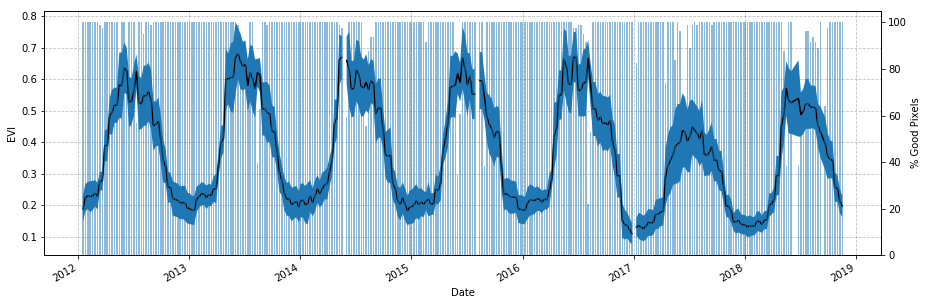

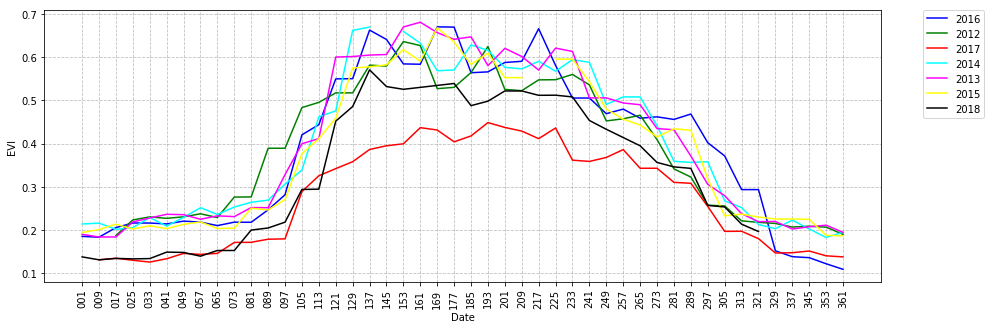

In [12]:
proddata_filt_scale = proddata_filt*float(scale)

prodstats = pd.DataFrame(
    np.column_stack(
        [
            proddata_filt_scale.mean(axis=1), 
            proddata_filt_scale.std(axis=1), 
            proddata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)
        ]
    ), 
    columns=['mean', 'sd', 'quality'], 
    index=pd.to_datetime(calendar_dates)
)

prodstats['year'] = [dt[0:4] for dt in calendar_dates]
prodstats['doy'] = doys
years = list(set([dt[0:4] for dt in calendar_dates]))
colors = ['blue', 'green','red','cyan','magenta','yellow','black']

# Plot time series
plt.rcParams['figure.figsize'] = (15,5)
fig, ax1 = plt.subplots()

ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('EVI')
ax1.plot(prodstats.index, prodstats['mean'], 'k-')
ax1.fill_between(prodstats.index, prodstats['mean']-prodstats['sd'], prodstats['mean']+prodstats['sd'])
ax1.tick_params(axis='y')
fig.autofmt_xdate()

ax2 = ax1.twinx()
ax2.set_ylabel('% Good Pixels')
ax2.bar(prodstats.index, prodstats['quality'], 5, alpha = 0.5)
ax2.tick_params(axis='y')

# Plot by year
plt.rcParams['figure.figsize'] = (15,5)
fig2, ax2 = plt.subplots()

ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed', alpha=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel('EVI')
for i, yr in enumerate(years):
    ax2.plot(prodstats[prodstats['year'] == yr]['doy'], prodstats[prodstats['year'] == yr]['mean'], 'k-', color = colors[i],  label=yr)
ax2.tick_params(axis='y')
plt.xticks(rotation=90)
fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# Bonus Content
-----

### MOD11A2 QC Table
Land Surface Temperature/Emissivity

In [13]:
import pandas as pd

# Create empty list to store QC bit information
QC_Data = []

# Iterate through the list of 8-bit integers and populate QC table with bit definitions.
for integer in range(0, 256, 1):
    bits = list(map(int, list("{0:b}".format(integer).zfill(8))))
    
    # Mandatory_QA bits description
    if (bits[6] == 0 and bits[7] == 0): Mandatory_QA = 'LST GOOD'
    if (bits[6] == 0 and bits[7] == 1): Mandatory_QA = 'LST Produced,Other Quality'
    if (bits[6] == 1 and bits[7] == 0): Mandatory_QA = 'No Pixel,clouds'
    if (bits[6] == 1 and bits[7] == 1): Mandatory_QA = 'No Pixel, Other QA'
        
    # Data_Quality bits description
    if (bits[4] == 0 and bits[5] == 0): Data_Quality = 'Good Data'
    if (bits[4] == 0 and bits[5] == 1): Data_Quality = 'Other Quality'
    if (bits[4] == 1 and bits[5] == 0): Data_Quality = 'TBD'
    if (bits[4] == 1 and bits[5] == 1): Data_Quality = 'TBD'
        
    # Emiss_Err bits description
    if (bits[2] == 0 and bits[3] == 0): Emiss_Err = 'Emiss Err <= .01'
    if (bits[2] == 0 and bits[3] == 1): Emiss_Err = 'Emiss Err <= .02'
    if (bits[2] == 1 and bits[3] == 0): Emiss_Err = 'Emiss Err <= .04'
    if (bits[2] == 1 and bits[3] == 1): Emiss_Err = 'Emiss Err > .04'
        
    # LST_Err bits description
    if (bits[0] == 0 and bits[1] == 0): LST_Err = 'LST Err <= 1K'
    if (bits[0] == 0 and bits[1] == 1): LST_Err = 'LST Err <= 3K'
    if (bits[0] == 1 and bits[1] == 0): LST_Err = 'LST Err <= 2K'
    if (bits[0] == 1 and bits[1] == 1): LST_Err = 'LST Err > 3K' 
    
    # Append this integers bit values and descriptions to list
    QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])
    

# Convert QC bits and descriptions to pandas data frame
QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
1,1,0,0,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
4,4,0,0,0,0,0,1,0,0,LST GOOD,Other Quality,Emiss Err <= .01,LST Err <= 1K
5,5,0,0,0,0,0,1,0,1,"LST Produced,Other Quality",Other Quality,Emiss Err <= .01,LST Err <= 1K
6,6,0,0,0,0,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Err <= .01,LST Err <= 1K
7,7,0,0,0,0,0,1,1,1,"No Pixel, Other QA",Other Quality,Emiss Err <= .01,LST Err <= 1K
8,8,0,0,0,0,1,0,0,0,LST GOOD,TBD,Emiss Err <= .01,LST Err <= 1K
9,9,0,0,0,0,1,0,0,1,"LST Produced,Other Quality",TBD,Emiss Err <= .01,LST Err <= 1K
